In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [19]:
df = pd.read_csv("preprocessed-data/krwvnd.csv")
df.head()

,Date,Close
0,2004-01-02,12.661377
1,2004-01-05,12.597076
2,2004-01-06,12.724485
3,2004-01-07,12.622449
4,2004-01-08,12.665998


In [20]:
df["Date"] = df.Date.map(lambda x: pd.to_datetime(x).date())
df = df.set_index("Date")

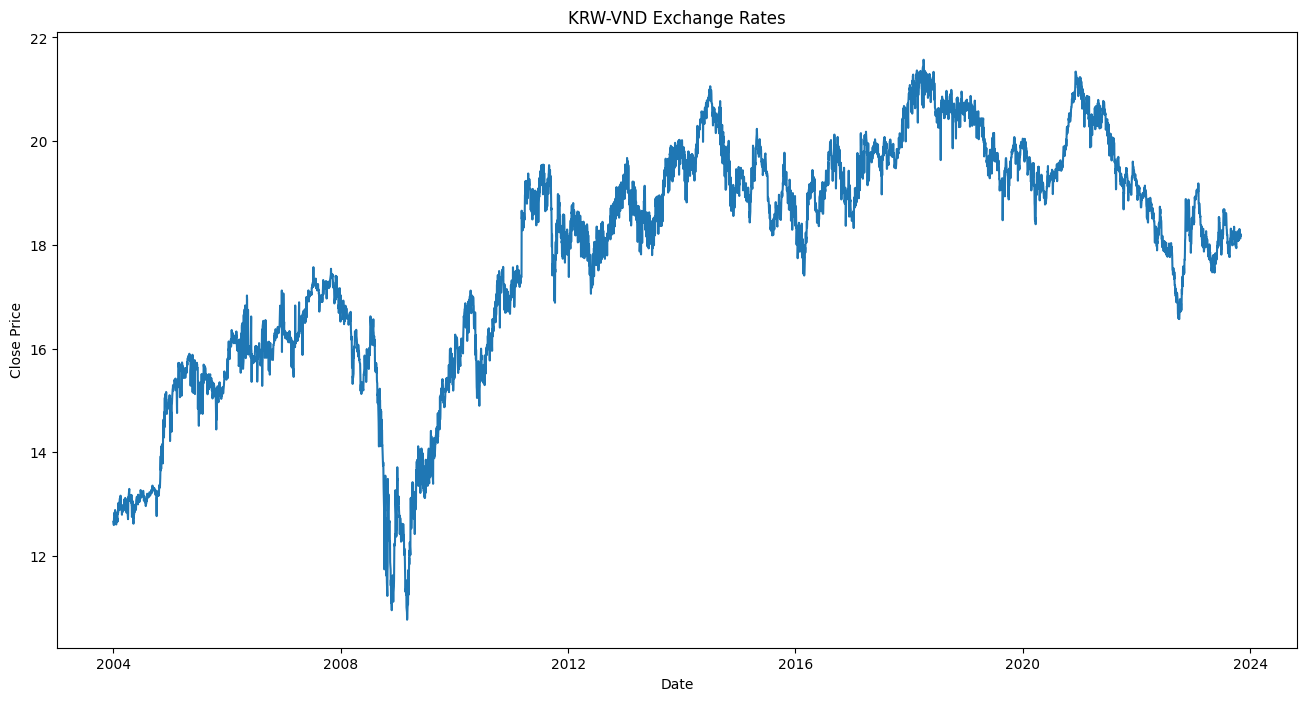

In [21]:
plt.figure(figsize=(16,8))
plt.plot(df)
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("KRW-VND Exchange Rates")
plt.show()

In [22]:
data = df.values
data = data.astype('float32')
data

array([[12.661377],
       [12.597076],
       [12.724485],
       ...,
       [18.123247],
       [18.211071],
       [18.17288 ]], dtype=float32)

In [23]:
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)
data

array([[0.1749875 ],
       [0.16903287],
       [0.18083173],
       ...,
       [0.6807906 ],
       [0.68892366],
       [0.68538696]], dtype=float32)

In [24]:
train_size = int(len(data) * 0.8)
test_size = len(data) - train_size
train, test = data[0:train_size,:], data[train_size:len(data),:]
print(len(train), len(test))

4783 1196


In [25]:
def create_dataset(dataset, look_back=1):
 dataX, dataY = [], []
 for i in range(len(dataset)-look_back-1):
  a = dataset[i:(i+look_back), 0]
  dataX.append(a)
  dataY.append(dataset[i + look_back, 0])
 return np.array(dataX), np.array(dataY)

In [38]:
look_back = 30
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [39]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [40]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001))
model.fit(trainX, trainY, epochs=10, batch_size=1, verbose=2)

Epoch 1/10
4752/4752 - 4s - loss: 0.0090 - 4s/epoch - 897us/step
Epoch 2/10
4752/4752 - 3s - loss: 7.2284e-04 - 3s/epoch - 701us/step
Epoch 3/10
4752/4752 - 3s - loss: 6.2780e-04 - 3s/epoch - 672us/step
Epoch 4/10
4752/4752 - 3s - loss: 5.9513e-04 - 3s/epoch - 660us/step
Epoch 5/10
4752/4752 - 4s - loss: 5.6251e-04 - 4s/epoch - 784us/step
Epoch 6/10
4752/4752 - 3s - loss: 5.6250e-04 - 3s/epoch - 695us/step
Epoch 7/10
4752/4752 - 3s - loss: 5.4542e-04 - 3s/epoch - 669us/step
Epoch 8/10
4752/4752 - 3s - loss: 5.2840e-04 - 3s/epoch - 689us/step
Epoch 9/10
4752/4752 - 3s - loss: 5.3477e-04 - 3s/epoch - 673us/step
Epoch 10/10
4752/4752 - 3s - loss: 5.3138e-04 - 3s/epoch - 639us/step


In [41]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

trainScore = mean_squared_error(trainY[0], trainPredict[:,0])
print('Train Score: %.4f MSE' % (trainScore))
testScore = mean_squared_error(testY[0], testPredict[:,0])
print('Test Score: %.4f MSE' % (testScore))

37/37 [==============================] - 0s 421us/step
Train Score: 0.0444 MSE
Test Score: 0.0206 MSE


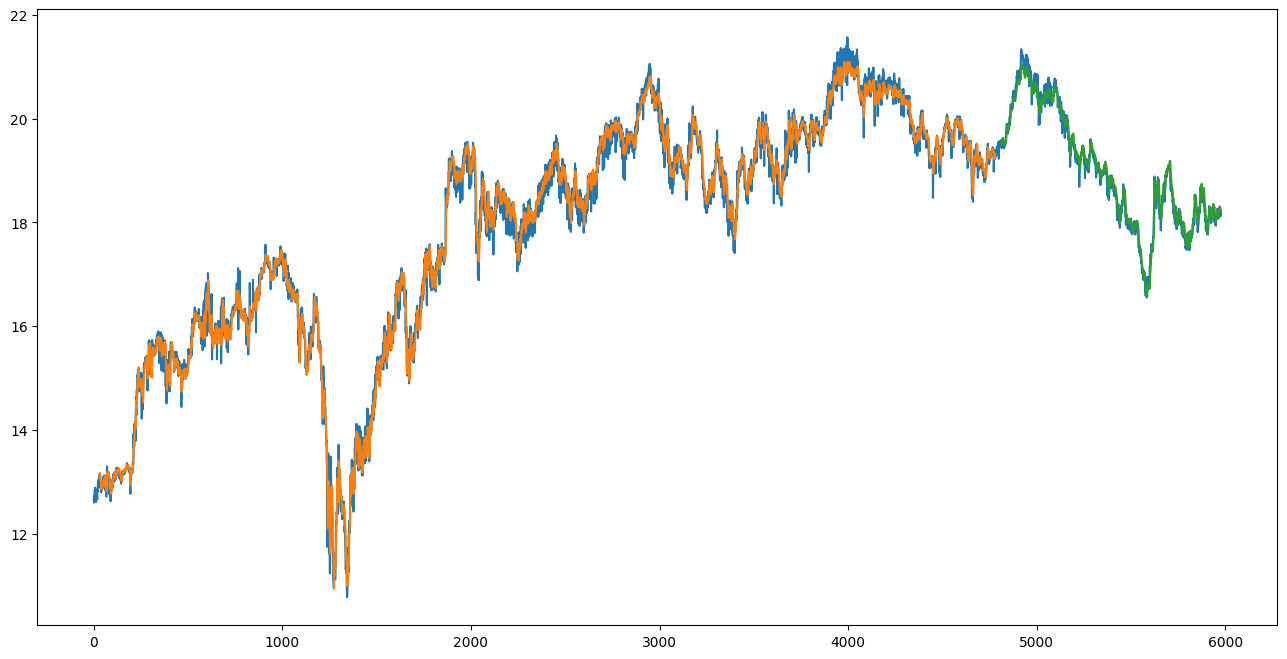

In [42]:
trainPredictPlot = np.empty_like(data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

testPredictPlot = np.empty_like(data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(data)-1, :] = testPredict

plt.figure(figsize=(16,8))
plt.plot(scaler.inverse_transform(data))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()